# Homework 3 (34 pts)

## Overview
This homework assignment will focus on exploring the spatial characteristics of Airbnb listings in Manhattan, New York City. By practicing K-means clustering, you will deepen your understanding of this method and how it can be applied in empirical studies.

## Grading
Each exercise will be graded based on the following rubrics:
- 2 points. Completed the task, presented the expected results, and codes were well documented and explained.
- 1 point. Completed the task with some disparity from the expected results.
- 0 point. Did not complete the excercise.

## Late submission policy
For late submission, every extra day after the due date will lead to 20% off of your points. Less than a day will be counted as one day. All submissions after the TA team posts the answers will not be accepted.

## 1. Read and Clean Data
### 1.1 Read and Clean Census Tract Data
Retrieving the census tract data follows the same process in Homework 2 so **ct** geodataframe is prepared for you.

In [1]:
# import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import matplotlib.pyplot as plt
# from shapely.geometry import Point
%matplotlib inline
# import cenpy
from pysal.lib import weights
import contextily
from shapely.geometry import shape

ct = pd.read_json("https://data.cityofnewyork.us/resource/63ge-mke6.json?$where=BoroName='Manhattan'")
ct['the_geom'] = ct['the_geom'].apply(shape)
ct = gpd.GeoDataFrame(ct, geometry='the_geom').set_crs(epsg = 4326)
ct.info()

C:\Users\RainC\AppData\Local\Temp\ipykernel_27236\3364062317.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   the_geom    310 non-null    geometry
 1   ctlabel     310 non-null    float64 
 2   borocode    310 non-null    int64   
 3   boroname    310 non-null    object  
 4   ct2020      310 non-null    int64   
 5   boroct2020  310 non-null    int64   
 6   ntaname     310 non-null    object  
 7   nta2020     310 non-null    object  
 8   cdta2020    310 non-null    object  
 9   cdtaname    310 non-null    object  
 10  geoid       310 non-null    int64   
 11  shape_leng  310 non-null    float64 
 12  shape_area  310 non-null    float64 
dtypes: float64(3), geometry(1), int64(4), object(5)
memory usage: 31.6+ KB


### 1.2 Read and Clean Airbnb Listing Data
The Airbnb listing data is also the same as Homework 2 so the geodataframe **listing** is prepared too.

In [2]:
listing_raw = pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2022-12-04/data/listings.csv.gz')
listing_raw.price = listing_raw.price.replace('[\$,]', '', regex=True).astype(float)
listing_g = gpd.GeoDataFrame(listing_raw, 
                             geometry = gpd.points_from_xy(listing_raw.longitude, 
                                                           listing_raw.latitude)).set_crs(epsg = 4326)
listing = gpd.tools.sjoin(listing_g, ct[['geoid', 'boroname', 'the_geom']], 
                          predicate="within", how='inner')
listing.info()

C:\ProgramData\Anaconda3\envs\gds_py\lib\site-packages\IPython\core\interactiveshell.py:3442: DtypeWarning: Columns (68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17333 entries, 0 to 34389
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            17333 non-null  int64   
 1   listing_url                                   17333 non-null  object  
 2   scrape_id                                     17333 non-null  int64   
 3   last_scraped                                  17333 non-null  object  
 4   source                                        17333 non-null  object  
 5   name                                          17325 non-null  object  
 6   description                                   17054 non-null  object  
 7   neighborhood_overview                         9538 non-null   object  
 8   picture_url                                   17333 non-null  object  
 9   host_id                                   

## 2. K-means Clustering
### 2.1 The Built-in K-means Clustering (16 pts)
You will use KMeans module from sklearn to find the Airbnb listing clusters based solely on the listing locations. Recall the in-class example: to prepare the proper input for KMeans function, what should be *X*? Write your code below to create *X*. (2 pts)

In [5]:
# create X - the location of the listing
X = [listing['geometry'].x, listing['geometry'].y]
# convert X to numpy array
X = np.array(X).T
X

array([[-73.98559   ,  40.75356   ],
       [-73.99003   ,  40.75672   ],
       [-73.98995   ,  40.75678   ],
       ...,
       [-73.94580567,  40.77255571],
       [-73.9479026 ,  40.77050002],
       [-73.97952   ,  40.7142    ]])

After correctly specifying X, use the KMeans module to quickly identify the clusters. Use `random` initialization, run `100` times of K-means algorithm around each centroid and specify `n_clusters` as 10 (2 pts)

Hint: You can refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) provided to learn how to add these parameters.

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, init='random', n_init=100)
kmeans.fit(X)

KMeans(init='random', n_clusters=10, n_init=100)

Create a plot to display your clustering results. Include the following:
- Clustered listing points, with marker size as 5. (2 pts)
- Centroids, with marker size as 10. (2 pts)
- Colored NTAs, with a grey edge color and 40% transparency. (2 pts) 

<AxesSubplot: >

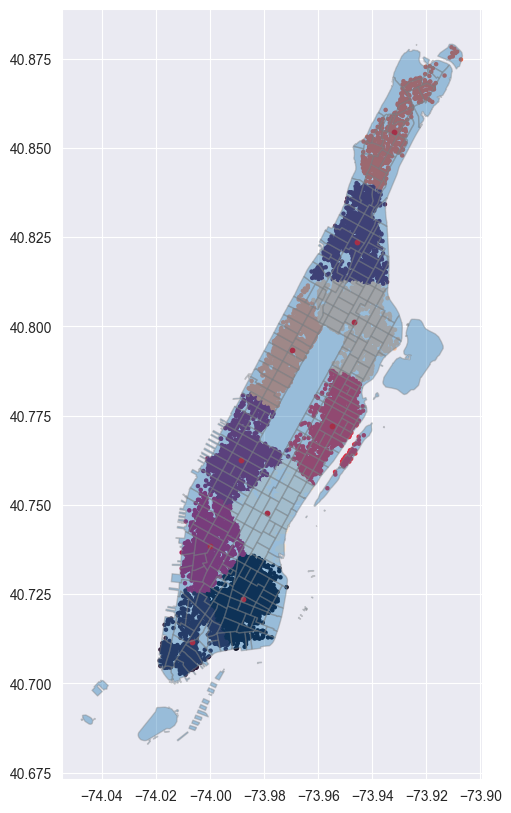

In [8]:
# plot the clustering results
fig, ax = plt.subplots(figsize=(10,10))
# clustering results
predict_result = kmeans.predict(X)
plt.scatter(X[:,0], X[:,1], s=5, c=predict_result)
centroids = kmeans.cluster_centers_
# plot centroids
plt.scatter(centroids[:,0], centroids[:,1], s=10, c='red')
# plot NTA
ct.plot(ax=ax, edgecolor='grey', alpha=0.4)

Based on the above steps, define a function `find_cluster()` with parameters `k` with output as the clustering result plot. (2 pts)

In [11]:
def find_cluster(k_cluster):
    """
    A function to find the clusters of Airbnb listings in Manhattan
    Assuming that datasets are prepared in advance.
    :param k_cluster: number of clusters
    :return: a clustering result plot
    """
    # fit the model
    kmeans = KMeans(n_clusters=k_cluster, init='random', n_init=100)
    kmeans.fit(X)
    # plot the clustering results
    fig, ax = plt.subplots(figsize=(10,10))
    # clustering results
    predict_result = kmeans.predict(X)
    plt.scatter(X[:,0], X[:,1], s=5, c=predict_result)
    centroids = kmeans.cluster_centers_
    # plot centroids
    plt.scatter(centroids[:,0], centroids[:,1], s=10, c='red')
    # plot NTA
    ct.plot(ax=ax, edgecolor='grey', alpha=0.4)
    # set title
    plt.title('K-means Clustering with {} clusters'.format(k_cluster))
    return plt.show()

Use `find_cluster()` function to experiment with 5 different numbers of `k_cluster`. Present your plots below. (2 pts)

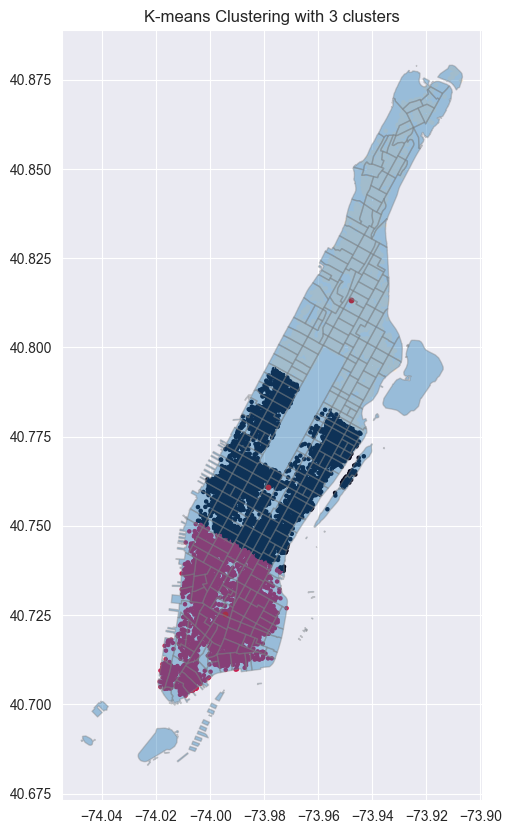

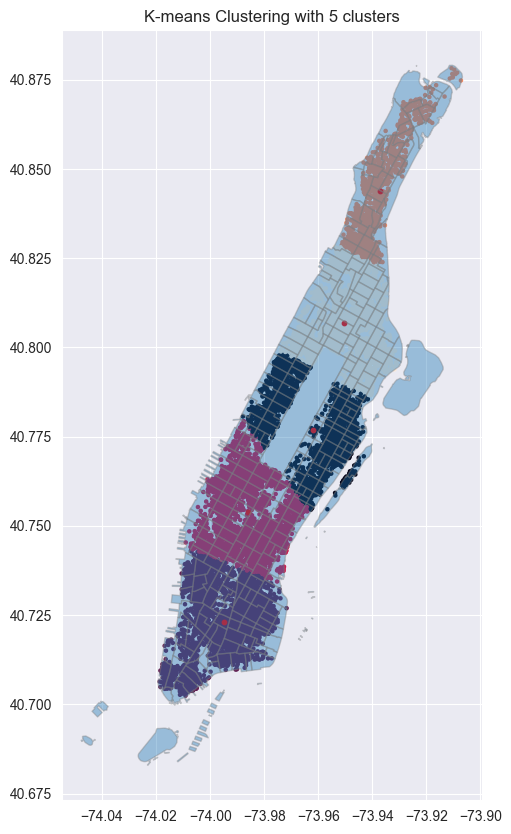

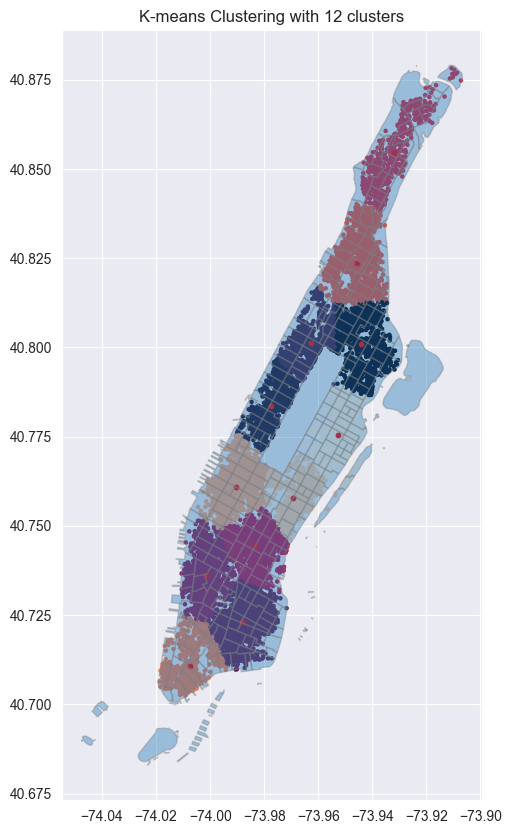

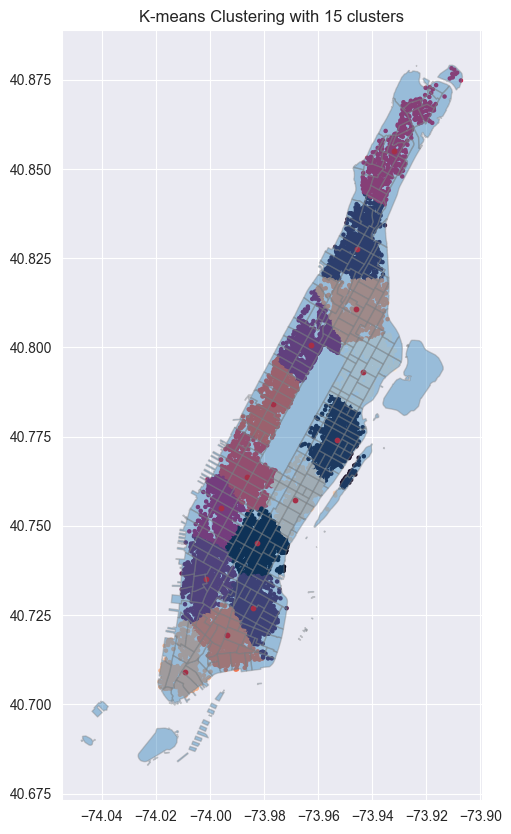

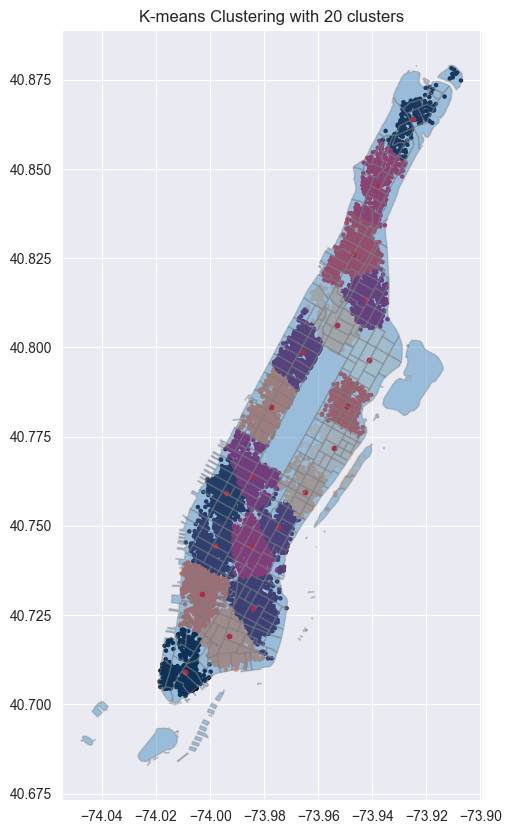

In [12]:
# insert your code here
find_cluster(3)
find_cluster(5)
find_cluster(12)
find_cluster(15)
find_cluster(20)

Compare the 6 clustering results. How do you interpret any discrepancies among them? How does the number of clusters influence the results? Also, discuss the implications of these results for future analyses that use the K-means algorithm. (2 pts)

Use markdown to write your answer.

Answer: a) The 6 clustering results are similar in general spatial distribution but varies based on the number of clusters. Higher cluster numbers can split natural clustering, while low cluster numbers can join two spatially separated clustering. For example, the two clusters seperated by the Central Park is categorized as a single cluster when k=3. Thus, while using K-means algorithm, it is important to have prior knowledge about the dataset or experiment with different clustering numbers to determine the optimal number of clusters.

### 2.2  Density-based Clustering Algorithm (DBSCAN) (18 pts)
Next, you will use DBSCAN algorithm to the same listing dataset and explore the difference between DBSCAN and K-means.

To conduct DBSCAN, you first need to specify `eps` and `min_samples` parameters. `eps` refers to the maximum distance between two samples for one to be considered as in the neighborhood of the other in radians rather than kilometers. Use the given equation to transform 8 kilometers into radians. 

`min_samples` refers to the number of samples (or total weight) in a neighborhood for a point to be considered as a core point. You will use 20 listings in this exercise as the minimum number of samples. (2 pts)

Hint: more details on DBSCAN can be found in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). 

In [14]:
import pointpats
from sklearn.cluster import DBSCAN
import seaborn

# def find_clusters(listing, eps_km, weights = None, name = None):
km = 8
epsilon = km / 6371.0088
minp = 20

Use `epsilon` and `minp` in the previous step for the DBSCAN function. Specify sample weight as the `price` in listing. Next, add the cluster labels to listing as a new column `lbls`. (2 pts)

In [29]:
# insert your code here
km = 8
epsilon = km / 6371.0088
minp = 20
db = DBSCAN(eps=epsilon, min_samples=minp).fit(X, sample_weight=listing['price'])
listing['lbls'] = db.labels_

How many clusters have been classified? (2 pts)

In [30]:
# insert your code here
len(set(listing['lbls'])) - (1 if -1 in listing['lbls'] else 0)

80

Plot the clustering results. Please include:
- The unclassified points (noise) in grey and size as 5. (2 pts)
- The clustered points in different colors and size as 10 (hint: check the [seaborn.scatterplot documentation](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) and specify parameter *hue* as `lbls`). Make sure to turn `lbls` into strings so that they are not read as continuous variables (2 pts)
- Base map and title. (2 pts)

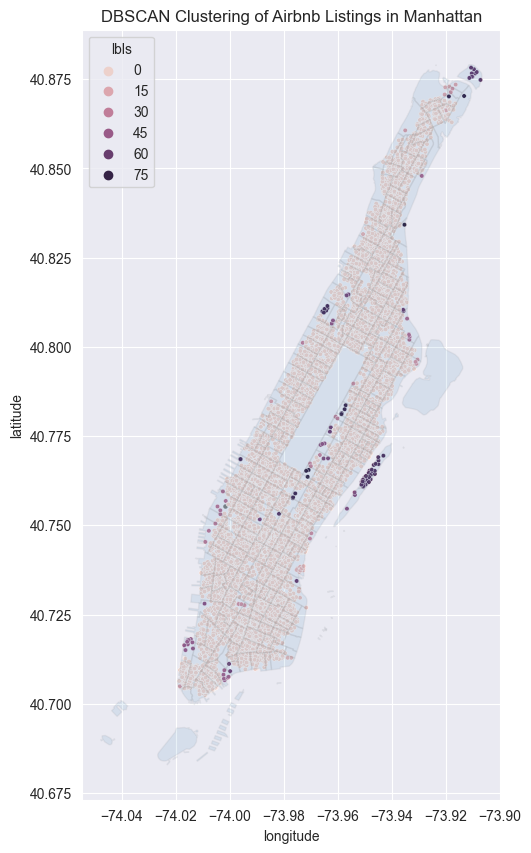

In [31]:
# plot the clustering results
fig, ax = plt.subplots(figsize=(10,10))
# unclassified points
noise = listing[listing['lbls'] == -1]
plt.scatter(noise['longitude'], noise['latitude'], s=5, c='grey')
# clustered points
clustered = listing[listing['lbls'] != -1]
seaborn.scatterplot(x='longitude', y='latitude', data=clustered, hue='lbls', s=10)
# add base map
ct.plot(ax=ax, edgecolor='grey', alpha=0.1)
# add title
plt.title('DBSCAN Clustering of Airbnb Listings in Manhattan')
plt.show()


Try a different `epsilon` with everything else the same. Plot your results in the same format. (2 pts)

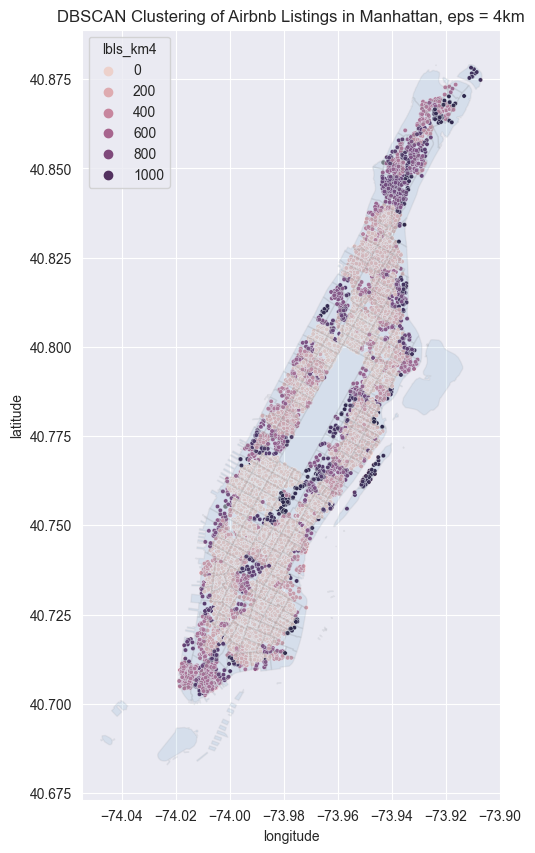

In [40]:
# lower the epsilon value
km = 4
epsilon = km / 6371.0088
minp = 20
db = DBSCAN(eps=epsilon, min_samples=minp).fit(X, sample_weight=listing['price'])
listing['lbls_km4'] = db.labels_
# plot the clustering results
fig, ax = plt.subplots(figsize=(10,10))
# unclassified points
noise = listing[listing['lbls_km4'] == -1]
plt.scatter(noise['longitude'], noise['latitude'], s=5, c='grey')
# clustered points
clustered = listing[listing['lbls_km4'] != -1]
seaborn.scatterplot(x='longitude', y='latitude', data=clustered, hue='lbls_km4', s=10)
# add base map
ct.plot(ax=ax, edgecolor='grey', alpha=0.1)
# add title
plt.title('DBSCAN Clustering of Airbnb Listings in Manhattan, eps = 4km')
plt.show()

Compare the two DBSCAN results obtained using different epsilon values and determine which one is a better reflection of the neighborhoods in Manhattan. Discuss the implications of your findings for future DBSCAN analyses. (2 pts) Use a markdown for your answer.

None of the DBSCAN results can be considered as a good reflection of the neighborhoods considering the high number of clusters. The DBSCAN algorithm failed to identify the relations between the neighborhoods and the listings. Due to the high concentration of the listings, most of the listings are considered as a cluster, while others scattering around the city edge are considered individual clusters. Thus, the DBSCAN algorithm is not suitable for this dataset.
For future analysis, it is important to acknowledge that the DBSCAN algorithm is not suitable for this kind of dataset, where a fixed eps value cannot accurately reflect the actual distribution of the data points.

Compare the clustering results obtained in section 2.1 and 2.2. List several pros and cons of the two K-Means implementation methods. (2 pts) Use a markdown for your answer.

Answer:
For K-means, the pros are that it is fast and efficient. With prior knowledge of the dataset, K-means can have optimal results by specifying the number of clusters.
The cons are that the algorithm is not stable since the initial condition is chosen randomly, thus it may not reach the global optimal result when the initial condition is poorly selected. Also, the algorithm only captures the clusters accurately when the clusters are spherical or with significant gaps.

For DBSCAN, the pros are that it can identify clusters of arbitrary shapes and sizes. It is also robust to outliers and noise since it can identify them as a separate noise cluster.
The cons are the difficulty in tuning the parameters - the eps and the min_samples. The algorithm is inaccurate with varying densities, as shown on the example above.